<div align="center">

<img src="https://www.telecom-paris.fr/wp-content-EvDsK19/uploads/2024/01/logo_telecom_ipparis_rvb_fond_h.png" alt="Telecom Paris Logo" width="300"/>

---

# **Projet Big Data - EDA**
## *IADATA700 - Kit Big Data*

# 🍂 Analyse statistique / Recettes / Saisonnalité

In [1]:
import sys
sys.path.append('../../')

# Imports de modules personnalisés
from _data_utils import *

# Imports standards
import warnings
import importlib

# Imports data science
import pandas as pd
import polars as pl
import numpy as np

# Imports visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Imports statistiques
from scipy import stats
from scipy.stats import (
    spearmanr, kendalltau, kruskal, chi2_contingency, chisquare, kstest,
    mannwhitneyu, f_oneway
)

# Imports machine learning
from sklearn.linear_model import LinearRegression, TheilSenRegressor

# Imports statsmodels
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

# Imports typing
from typing import Dict, List, Tuple, Optional, Union
from configparser import ConfigParser

# Configuration
warnings.filterwarnings('ignore')

# Configuration graphique
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ Import réussi !")

✅ _data_utils module chargé (common + ratings + recipes)
✅ Import réussi !
✅ Import réussi !


## 📥 Chargement des données

In [2]:
# 🚀 Pipeline complet : charge + nettoie + enrichit
df = load_clean_recipes(save_to_s3=False) # True pour enregistrer le ficher final_recipes.parquet

print(f"✅ Dataset prêt : {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
print(f"📅 Période : {df['year'].min()} - {df['year'].max()}")

# 📊 Rapport de qualité
report = analyze_recipe_quality(df)

1️⃣ Chargement des données brutes...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✅ Recettes chargées depuis S3 : 231,637 lignes × 12 colonnes

2️⃣ Nettoyage des données...
🧹 Nettoyage des recettes...
   ✓ 18,482 recettes avec minutes invalides (<1 ou >180)
   ℹ️  Seuils calculés (IQ 90% = Q5%-Q95%):
      • n_steps: [2, 24] (médiane=9, moyenne=9.7)
      • n_ingredients: [3, 17] (médiane=9, moyenne=9.0)
   ✓ 13,088 recettes avec n_steps ou n_ingredients aberrants (hors IQ 90%)
✅ Nettoyage terminé : 200,066 recettes conservées (31,571 supprimées)

3️⃣ Enrichissement des features...
⚙️ Enrichissement des recettes...
✅ Enrichissement terminé : 28 colonnes totales

✅ Pipeline complet terminé !
✅ Dataset prêt : 200,066 lignes × 28 colonnes
📅 Période : 1999 - 2018
📊 Analyse de qualité des données...

📋 RAPPORT DE QUALITÉ - RAW_RECIPES
📦 Dimensions : 200,066 lignes × 28 colonnes
🔄 Doublons : 0
⚠️  Valeurs nulles :
   • description: 3,770 (1.9%)
   • description_length: 3,770 (1.9%)
⏱️ Minutes : médiane=35, moyenne=42.4, max=180
🔜 Steps : médiane=8, moyenne=9.2, max=24
🥕 I

## Analyse statistique des recettes postées

### Analyse 1 : Évolution du volume de recettes
#### Visualisation

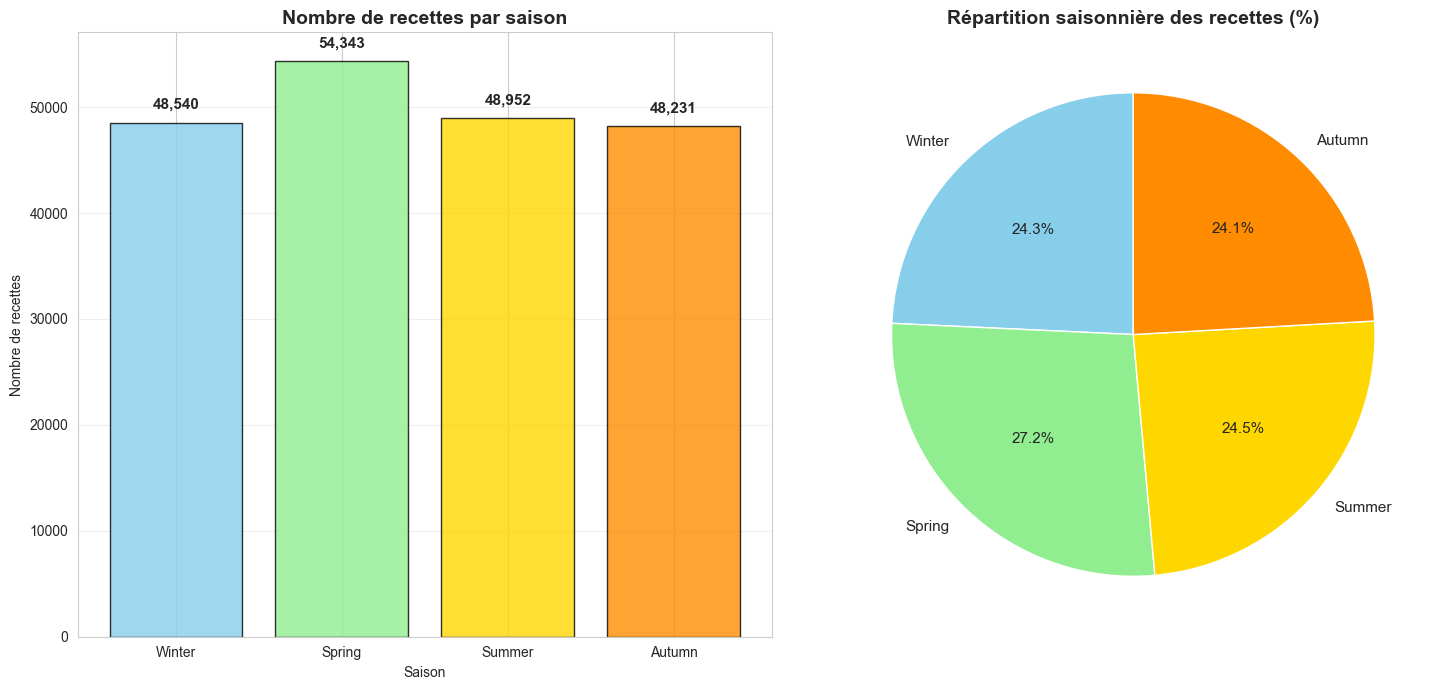

In [3]:
recipes_per_season = (df.group_by("season").agg(pl.len().alias("n_recipes")).sort("season").to_pandas())

# Visualization
season_order = ["Winter", "Spring", "Summer", "Autumn"]
season_colors = {"Winter": "#87CEEB", "Spring": "#90EE90", "Summer": "#FFD700", "Autumn": "#FF8C00"}
recipes_per_season = recipes_per_season.set_index('season').loc[season_order].reset_index()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

colors = [season_colors[season] for season in recipes_per_season['season']]
bars = ax1.bar(recipes_per_season['season'], recipes_per_season['n_recipes'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title('Nombre de recettes par saison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Saison')
ax1.set_ylabel('Nombre de recettes')
ax1.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, recipes_per_season['n_recipes']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
             f'{val:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

sizes = recipes_per_season['n_recipes']
labels = recipes_per_season['season']
colors_pie = [season_colors[season] for season in recipes_per_season['season']]
wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%',
                                   startangle=90, textprops={'fontsize': 11})
ax2.set_title('Répartition saisonnière des recettes (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

#### Tests statistiques

In [4]:
observed = recipes_per_season['n_recipes'].values
expected_uniform = [recipes_per_season['n_recipes'].sum() / 4] * 4

chi2_stat, chi2_p = chisquare(observed, expected_uniform)
print(f"Test Chi-2 (uniformité): χ² = {chi2_stat:.4f} (p = {chi2_p:.6f})")
print(f"Répartition uniforme: {'❌ Rejetée' if chi2_p < 0.05 else '✅ Acceptée'}")

mean_recipes = recipes_per_season['n_recipes'].mean()
std_recipes = recipes_per_season['n_recipes'].std()
cv = (std_recipes / mean_recipes) * 100

print(f"\nVariabilité saisonnière:")
print(f"   • Moyenne: {mean_recipes:.0f} recettes/saison")
print(f"   • Écart-type: {std_recipes:.0f} recettes")
print(f"   • Coefficient de variation: {cv:.1f}%")

print(f"\n🔍 ÉCARTS PAR RAPPORT À LA MOYENNE:")
print("-" * 50)

for _, row in recipes_per_season.iterrows():
    season_fr = row['season']
    count = int(row['n_recipes'])
    deviation = count - mean_recipes
    deviation_pct = (deviation / mean_recipes) * 100
    status = "📈" if deviation > 0 else "📉" if deviation < -std_recipes else "➡️"
    print(f"{status} {season_fr:>12}: {count:>7,} ({deviation:+6.0f}, {deviation_pct:+5.1f}%)")


Test Chi-2 (uniformité): χ² = 504.2301 (p = 0.000000)
Répartition uniforme: ❌ Rejetée

Variabilité saisonnière:
   • Moyenne: 50016 recettes/saison
   • Écart-type: 2899 recettes
   • Coefficient de variation: 5.8%

🔍 ÉCARTS PAR RAPPORT À LA MOYENNE:
--------------------------------------------------
➡️       Winter:  48,540 ( -1476,  -3.0%)
📈       Spring:  54,343 ( +4326,  +8.7%)
➡️       Summer:  48,952 ( -1064,  -2.1%)
➡️       Autumn:  48,231 ( -1786,  -3.6%)


#### Interprétation

> **💡 Interprétation:** 
>  
> Le **test du χ²** montre que la **répartition saisonnière** du nombre de recettes **n’est pas uniforme**, avec des **écarts significatifs** entre les saisons.  
>
> Le **printemps**, nettement au-dessus de la moyenne (+4236, +8,7%), indique une **saisonnalité marquée** dans la production, tandis que les autres saisons restent **relativement stables**.  
>

### Analyse 2: Évolution de la durée moyenne
#### Visualisation

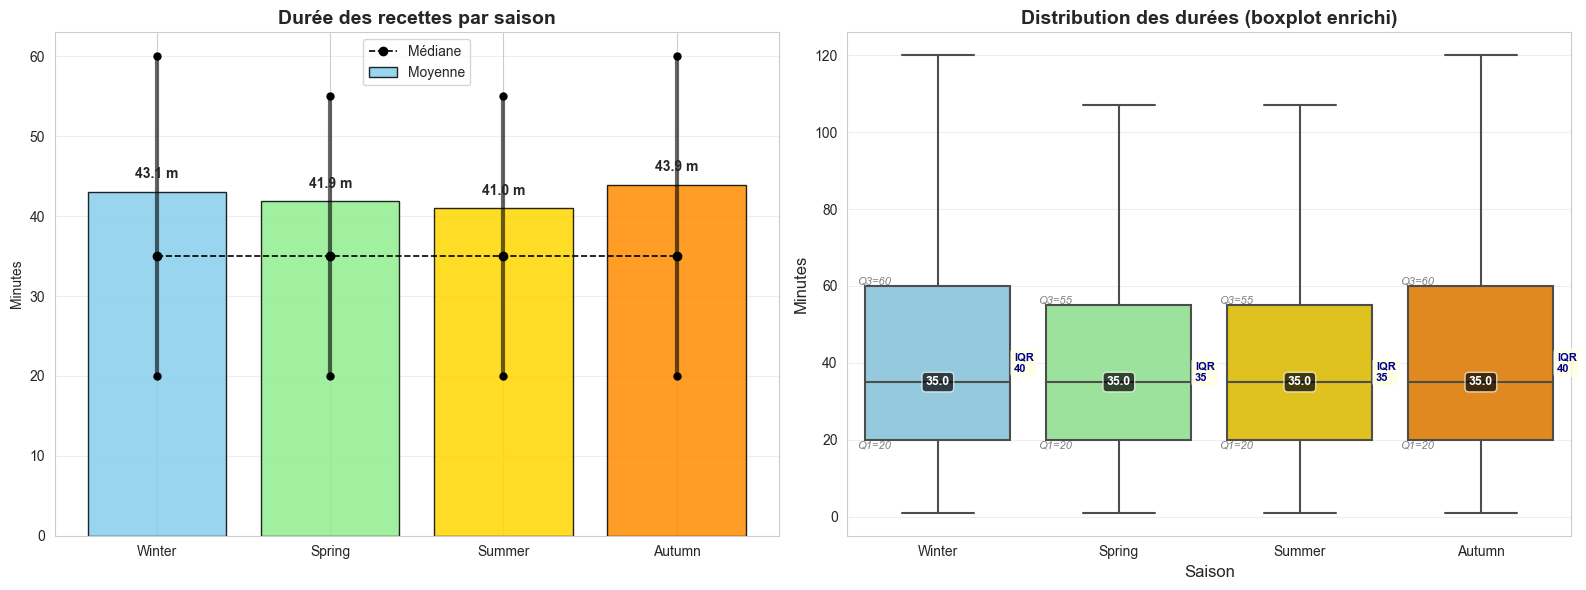

In [5]:
minutes_by_season = (df.group_by("season")
    .agg([
        pl.mean("minutes").alias("mean_minutes"), 
        pl.median("minutes").alias("median_minutes"),
        pl.quantile("minutes",0.25).alias("q25"), 
        pl.quantile("minutes",0.75).alias("q75"), 
        pl.len().alias("n_recipes")
    ]).sort("season").to_pandas().set_index("season").loc[season_order].reset_index())
minutes_by_season["IQR"] = minutes_by_season["q75"] - minutes_by_season["q25"]

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6))
bar_colors=[season_colors[s] for s in minutes_by_season.season]

# --- GRAPHIQUE 1 : Barres + Médiane + IQR ---
ax1.bar(minutes_by_season.season, minutes_by_season.mean_minutes, 
        color=bar_colors, alpha=.85, edgecolor='black', lw=1, label='Moyenne')
ax1.plot(minutes_by_season.season, minutes_by_season.median_minutes, 
         'o--', color='black', lw=1.2, ms=6, label='Médiane')
for s,m,med,q25,q75,_n,_iqr in minutes_by_season[['season','mean_minutes','median_minutes','q25','q75','n_recipes','IQR']].itertuples(index=False):
    ax1.vlines(s,q25,q75,color='black',lw=3,alpha=.6)
    ax1.scatter([s],[q25],color='black',s=25)
    ax1.scatter([s],[q75],color='black',s=25)
    ax1.text(s,m*1.03,f"{m:.1f} m",ha='center',va='bottom',fontsize=10,fontweight='bold')
ax1.set_title("Durée des recettes par saison",fontsize=14,fontweight='bold')
ax1.set_ylabel("Minutes")
ax1.grid(axis='y',alpha=.3)
ax1.legend()

# --- GRAPHIQUE 2 : Boxplot enrichi ---
bp = sns.boxplot(data=df.to_pandas(), x='season', y='minutes', order=season_order,
                 palette=[season_colors[s] for s in season_order], ax=ax2, 
                 showfliers=False, linewidth=1.5)

# Annotations : médiane, Q1, Q3, IQR sur chaque boîte
for i, season in enumerate(season_order):
    season_data = minutes_by_season[minutes_by_season['season'] == season].iloc[0]
    median = season_data['median_minutes']
    q25 = season_data['q25']
    q75 = season_data['q75']
    iqr = season_data['IQR']
    
    # Médiane (ligne centrale)
    ax2.text(i, median, f'{median:.1f}', 
             ha='center', va='center', fontsize=9, fontweight='bold', 
             color='white', bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
    
    # Q1 (bas de la boîte)
    ax2.text(i-0.35, q25, f'Q1={q25:.0f}', 
             ha='center', va='top', fontsize=8, color='gray', style='italic')
    
    # Q3 (haut de la boîte)
    ax2.text(i-0.35, q75, f'Q3={q75:.0f}', 
             ha='center', va='bottom', fontsize=8, color='gray', style='italic')
    
    # IQR (à côté de la boîte)
    ax2.text(i+0.42, (q25+q75)/2, f'IQR\n{iqr:.0f}', 
             ha='left', va='center', fontsize=8, color='darkblue', fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.25', facecolor='lightyellow', alpha=0.8))

ax2.set_title("Distribution des durées (boxplot enrichi)", fontsize=14, fontweight='bold')
ax2.set_xlabel("Saison", fontsize=12)
ax2.set_ylabel("Minutes", fontsize=12)
ax2.grid(axis='y', alpha=.3)

plt.tight_layout()
plt.show()

#### Tests statistiques

In [6]:
# Résumé + Test Kruskal 
print("\nRésumé statistique par saison (minutes):\n" + "-"*55)
for s,m,med,q25,q75,iqr,n in minutes_by_season[['season','mean_minutes','median_minutes','q25','q75','IQR','n_recipes']].itertuples(index=False):
    print(f"{s:<8} | Moy:{m:6.1f} | Med:{med:6.1f} | Q25:{q25:6.1f} | Q75:{q75:6.1f} | IQR:{iqr:6.1f} | n={n:,}")
    
kw_stat, kw_p = kruskal(*[df.to_pandas().query('season==@s')['minutes'].values for s in season_order])
print(f"\nKruskal-Wallis: H={kw_stat:.3f}, p={kw_p:.6f}")
print(f"Différences significatives" if kw_p<0.05 else "Pas de différence nette")


Résumé statistique par saison (minutes):
-------------------------------------------------------
Winter   | Moy:  43.1 | Med:  35.0 | Q25:  20.0 | Q75:  60.0 | IQR:  40.0 | n=48,540
Spring   | Moy:  41.9 | Med:  35.0 | Q25:  20.0 | Q75:  55.0 | IQR:  35.0 | n=54,343
Summer   | Moy:  41.0 | Med:  35.0 | Q25:  20.0 | Q75:  55.0 | IQR:  35.0 | n=48,952
Autumn   | Moy:  43.9 | Med:  35.0 | Q25:  20.0 | Q75:  60.0 | IQR:  40.0 | n=48,231

Kruskal-Wallis: H=346.926, p=0.000000
Différences significatives

Kruskal-Wallis: H=346.926, p=0.000000
Différences significatives


#### Interprétation

> **💡 Interprétation :**  
> 
> Le **test de Kruskal-Wallis** (H = 346.93, p < 0.001) confirme des **différences significatives** de durée entre les saisons.  
> 
> Les recettes postées en **automne** et en **hiver** sont **plus longues** que celles partagées en **été**, avec une durée moyenne de **43,9 minutes** en **automne** et **43,1 minutes** en **hiver**, contre **41,0 minutes** en **été** et **41,9 minutes** au **printemps**.
> 

### Analyse 3: Évolution de la complexité
#### Visualisation

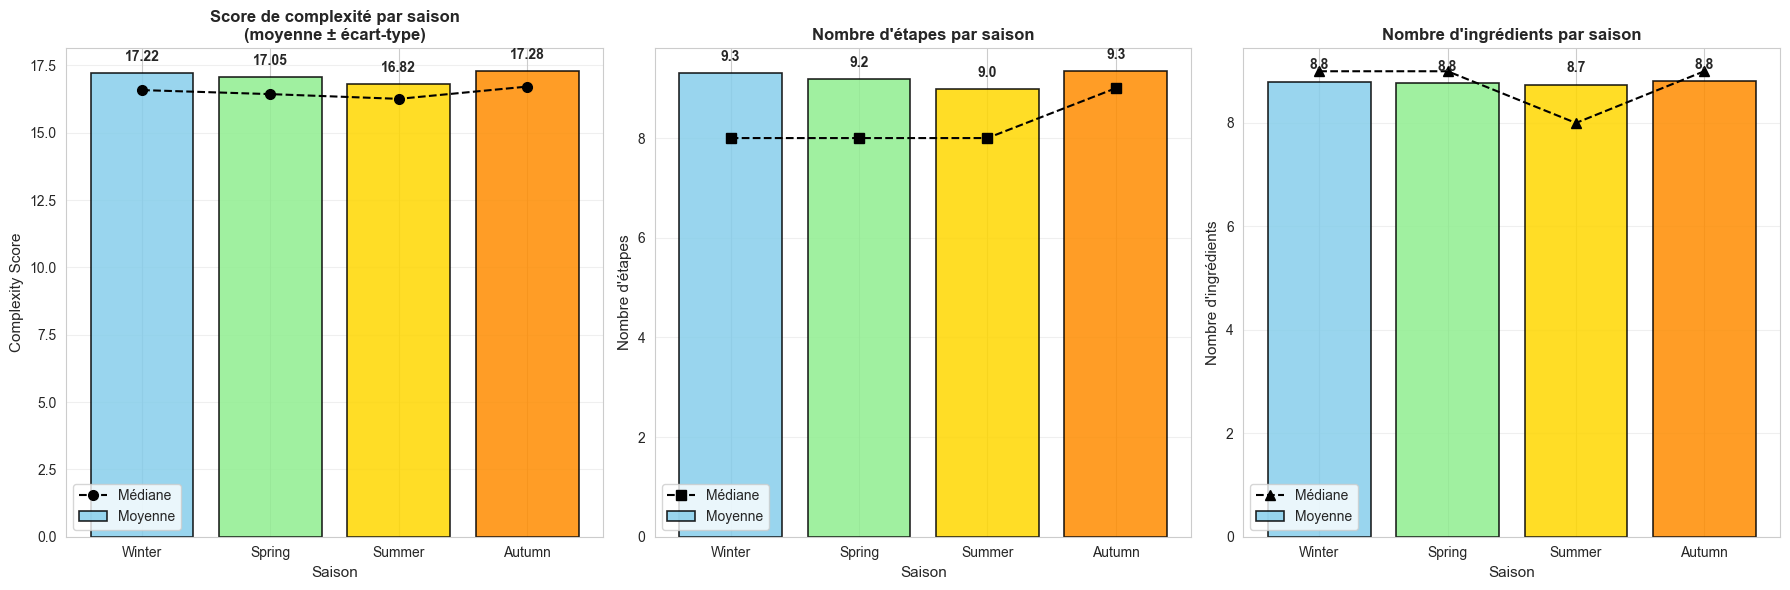

In [7]:
# 📊 Agrégation des données de complexité par saison
complexity_by_season = (
    df.group_by("season")
    .agg([
        pl.mean("complexity_score").alias("mean_complexity"),
        pl.median("complexity_score").alias("median_complexity"),
        pl.std("complexity_score").alias("std_complexity"),
        pl.mean("n_steps").alias("mean_steps"),
        pl.median("n_steps").alias("median_steps"),
        pl.mean("n_ingredients").alias("mean_ingredients"),
        pl.median("n_ingredients").alias("median_ingredients"),
        pl.quantile("complexity_score", 0.25).alias("q25_complexity"),
        pl.quantile("complexity_score", 0.75).alias("q75_complexity"),
        pl.count("id").alias("count_recipes")
    ])
    .sort("season").to_pandas()
    .set_index("season").loc[season_order].reset_index()
)

# Configuration des couleurs saisonnières
colors_dict = {s: season_colors[s] for s in season_order}

# --- VISUALISATION EN 3 PANELS ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# --- GRAPHIQUE 1 : Score de complexité (barres + médiane + IQR) ---
ax1 = axes[0]
bar_colors = [colors_dict[s] for s in complexity_by_season['season']]

bars = ax1.bar(complexity_by_season['season'], complexity_by_season['mean_complexity'],
               color=bar_colors, alpha=0.85, edgecolor='black', linewidth=1.2,
               label='Moyenne')

# Médiane en ligne pointillée
ax1.plot(complexity_by_season['season'], complexity_by_season['median_complexity'],
         'o--', color='black', linewidth=1.5, markersize=7, label='Médiane')

# Barres d'erreur (std)
for i, row in complexity_by_season.iterrows():    
    # Annotations des valeurs
    ax1.text(i, row['mean_complexity'] * 1.02,
             f"{row['mean_complexity']:.2f}",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

ax1.set_title('Score de complexité par saison\n(moyenne ± écart-type)',
              fontsize=12, fontweight='bold')
ax1.set_xlabel('Saison', fontsize=11)
ax1.set_ylabel('Complexity Score', fontsize=11)
ax1.grid(axis='y', alpha=0.3)
ax1.legend(loc='best')

# --- GRAPHIQUE 2 : Nombre d'étapes ---
ax2 = axes[1]
bars2 = ax2.bar(complexity_by_season['season'], complexity_by_season['mean_steps'],
                color=bar_colors, alpha=0.85, edgecolor='black', linewidth=1.2,
                label='Moyenne')

ax2.plot(complexity_by_season['season'], complexity_by_season['median_steps'],
         's--', color='black', linewidth=1.5, markersize=7, label='Médiane')

for i, row in complexity_by_season.iterrows():
    ax2.text(i, row['mean_steps'] * 1.02,
             f"{row['mean_steps']:.1f}",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_title('Nombre d\'étapes par saison',
              fontsize=12, fontweight='bold')
ax2.set_xlabel('Saison', fontsize=11)
ax2.set_ylabel('Nombre d\'étapes', fontsize=11)
ax2.grid(axis='y', alpha=0.3)
ax2.legend(loc='best')

# --- GRAPHIQUE 3 : Nombre d'ingrédients ---
ax3 = axes[2]
bars3 = ax3.bar(complexity_by_season['season'], complexity_by_season['mean_ingredients'],
                color=bar_colors, alpha=0.85, edgecolor='black', linewidth=1.2,
                label='Moyenne')

ax3.plot(complexity_by_season['season'], complexity_by_season['median_ingredients'],
         '^--', color='black', linewidth=1.5, markersize=7, label='Médiane')

for i, row in complexity_by_season.iterrows():
    ax3.text(i, row['mean_ingredients'] * 1.02,
             f"{row['mean_ingredients']:.1f}",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

ax3.set_title('Nombre d\'ingrédients par saison',
              fontsize=12, fontweight='bold')
ax3.set_xlabel('Saison', fontsize=11)
ax3.set_ylabel('Nombre d\'ingrédients', fontsize=11)
ax3.grid(axis='y', alpha=0.3)
ax3.legend(loc='best')

plt.tight_layout()
plt.show()

#### Tests statistiques

In [8]:
# 📊 TESTS STATISTIQUES DE COMPLEXITÉ PAR SAISON
print("=" * 80)
print("📊 ANALYSE STATISTIQUE DE LA COMPLEXITÉ PAR SAISON")
print("=" * 80)

# --- 1. RÉSUMÉ STATISTIQUE ---
print("\n1️⃣ RÉSUMÉ STATISTIQUE PAR SAISON")
print("-" * 80)
print(f"{'Saison':<10} | {'Moy Cpx':<8} | {'Med Cpx':<8} | {'Std':<8} | {'Steps':<7} | {'Ingr.':<7} | {'n':<8}")
print("-" * 80)
for _, row in complexity_by_season.iterrows():
    print(f"{row['season']:<10} | {row['mean_complexity']:>8.3f} | {row['median_complexity']:>8.3f} | "
          f"{row['std_complexity']:>8.3f} | {row['mean_steps']:>7.2f} | "
          f"{row['mean_ingredients']:>7.2f} | {row['count_recipes']:>8,}")

# --- 2. TEST DE KRUSKAL-WALLIS (complexité) ---
print("\n2️⃣ TEST DE KRUSKAL-WALLIS : Complexity Score")
print("-" * 80)
groups_complexity = [df.to_pandas().query('season==@s')['complexity_score'].values 
                     for s in season_order]
kw_stat_cpx, kw_p_cpx = kruskal(*groups_complexity)
print(f"Statistique H   : {kw_stat_cpx:.4f}")
print(f"p-value         : {kw_p_cpx:.6e}")
print(f"Conclusion      : {'✅ Différences significatives' if kw_p_cpx < 0.05 else '❌ Pas de différence significative'} (α=0.05)")

# --- 3. TEST DE KRUSKAL-WALLIS (n_steps) ---
print("\n3️⃣ TEST DE KRUSKAL-WALLIS : Nombre d'étapes")
print("-" * 80)
groups_steps = [df.to_pandas().query('season==@s')['n_steps'].values 
                for s in season_order]
kw_stat_steps, kw_p_steps = kruskal(*groups_steps)
print(f"Statistique H   : {kw_stat_steps:.4f}")
print(f"p-value         : {kw_p_steps:.6e}")
print(f"Conclusion      : {'✅ Différences significatives' if kw_p_steps < 0.05 else '❌ Pas de différence significative'} (α=0.05)")

# --- 4. TEST DE KRUSKAL-WALLIS (n_ingredients) ---
print("\n4️⃣ TEST DE KRUSKAL-WALLIS : Nombre d'ingrédients")
print("-" * 80)
groups_ingr = [df.to_pandas().query('season==@s')['n_ingredients'].values 
               for s in season_order]
kw_stat_ingr, kw_p_ingr = kruskal(*groups_ingr)
print(f"Statistique H   : {kw_stat_ingr:.4f}")
print(f"p-value         : {kw_p_ingr:.6e}")
print(f"Conclusion      : {'✅ Différences significatives' if kw_p_ingr < 0.05 else '❌ Pas de différence significative'} (α=0.05)")

# --- 5. VARIABILITÉ SAISONNIÈRE ---
print("\n6️⃣ VARIABILITÉ SAISONNIÈRE")
print("-" * 80)
mean_cpx = complexity_by_season['mean_complexity'].mean()
std_cpx = complexity_by_season['mean_complexity'].std()
cv_cpx = (std_cpx / mean_cpx) * 100

print(f"Moyenne globale (complexité)  : {mean_cpx:.4f}")
print(f"Écart-type inter-saisons      : {std_cpx:.4f}")
print(f"Coefficient de variation      : {cv_cpx:.2f}%")

print("\n📊 ÉCARTS PAR RAPPORT À LA MOYENNE :")
print("-" * 80)
for _, row in complexity_by_season.iterrows():
    deviation = row['mean_complexity'] - mean_cpx
    deviation_pct = (deviation / mean_cpx) * 100
    status = "📈" if deviation > std_cpx else "📉" if deviation < -std_cpx else "➡️"
    print(f"{status} {row['season']:<10} : {row['mean_complexity']:.4f} "
          f"({deviation:+.4f}, {deviation_pct:+.2f}%)")

print("\n" + "=" * 80)

📊 ANALYSE STATISTIQUE DE LA COMPLEXITÉ PAR SAISON

1️⃣ RÉSUMÉ STATISTIQUE PAR SAISON
--------------------------------------------------------------------------------
Saison     | Moy Cpx  | Med Cpx  | Std      | Steps   | Ingr.   | n       
--------------------------------------------------------------------------------
Winter     |   17.223 |   16.584 |    5.943 |    9.30 |    8.80 |   48,540
Spring     |   17.052 |   16.434 |    5.926 |    9.18 |    8.77 |   54,343
Summer     |   16.821 |   16.258 |    5.876 |    8.99 |    8.74 |   48,952
Autumn     |   17.283 |   16.714 |    5.926 |    9.34 |    8.81 |   48,231

2️⃣ TEST DE KRUSKAL-WALLIS : Complexity Score
--------------------------------------------------------------------------------
Statistique H   : 173.3569
p-value         : 2.398360e-37
Conclusion      : ✅ Différences significatives (α=0.05)

3️⃣ TEST DE KRUSKAL-WALLIS : Nombre d'étapes
--------------------------------------------------------------------------------
Statistiq

#### Interprétation

> **💡 Interprétation :**  
> 
> Les **tests de Kruskal-Wallis** révèlent des **différences significatives** de complexité entre les saisons (p < 0.001).  
> 
> Les recettes postées en **hiver** et en **automne** sont plus élaborées (plus d'étapes et d'ingrédients), tandis que les recettes postées en **été** privilégie des préparations simplifiées. Cette **saisonnalité marquée** reflète les habitudes culinaires : plats mijotés en saison froide vs. recettes rapides et fraîches en période estivale.

### Analyse 4: Évolution nutritionnelle
#### Visualisation

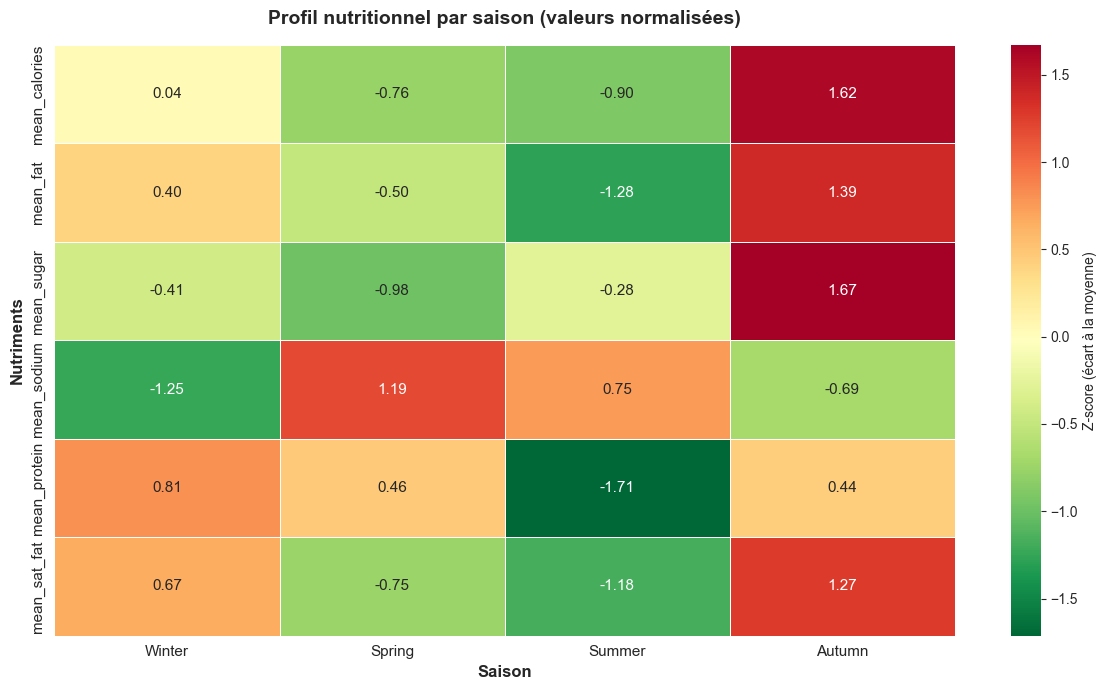

In [9]:
# 📊 Agrégation des données nutritionnelles par saison
nutrition_by_season = (
    df.group_by("season")
    .agg([
        pl.mean("calories").alias("mean_calories"),
        pl.mean("total_fat_pct").alias("mean_fat"),
        pl.mean("sugar_pct").alias("mean_sugar"),
        pl.mean("sodium_pct").alias("mean_sodium"),
        pl.mean("protein_pct").alias("mean_protein"),
        pl.mean("sat_fat_pct").alias("mean_sat_fat"),
        pl.count("id").alias("count_recipes")
    ])
    .sort("season")
)

# Conversion en pandas et réordonnancement
nutrition_by_season = (
    nutrition_by_season.to_pandas()
    .set_index("season")
    .loc[season_order]
    .reset_index()
)

# --- HEATMAP NUTRITIONNELLE ---
fig, ax = plt.subplots(figsize=(12, 7))

# Normalisation des valeurs pour comparaison
nutrition_matrix = nutrition_by_season[['season', 'mean_calories', 'mean_fat', 
                                         'mean_sugar', 'mean_sodium', 
                                         'mean_protein', 'mean_sat_fat']].set_index('season')

# Normalisation par z-score pour chaque nutriment
nutrition_norm = nutrition_matrix.apply(stats.zscore, axis=0)

# Heatmap
sns.heatmap(nutrition_norm.T, annot=True, fmt='.2f', cmap='RdYlGn_r',
            cbar_kws={'label': 'Z-score (écart à la moyenne)'}, 
            linewidths=0.5, ax=ax, annot_kws={'fontsize': 11})

ax.set_title('Profil nutritionnel par saison (valeurs normalisées)',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Saison', fontsize=12, fontweight='bold')
ax.set_ylabel('Nutriments', fontsize=12, fontweight='bold')
ax.tick_params(axis='both', labelsize=11)

plt.tight_layout()
plt.show()

#### Tests statistiques

In [10]:
# 📊 TESTS STATISTIQUES NUTRITIONNELS PAR SAISON
print("=" * 80)
print("📊 ANALYSE STATISTIQUE DES VALEURS NUTRITIONNELLES PAR SAISON")
print("=" * 80)

# --- 1. RÉSUMÉ STATISTIQUE ---
print("\n1️⃣ RÉSUMÉ STATISTIQUE PAR SAISON")
print("-" * 80)
print(f"{'Saison':<10} | {'Cal (kcal)':<10} | {'Lipides (%)':<12} | {'Sucre (%)':<10} | "
      f"{'Sodium (%)':<12} | {'Protéines (%)':<13} | {'n':<10}")
print("-" * 80)
for _, row in nutrition_by_season.iterrows():
    print(f"{row['season']:<10} | {row['mean_calories']:>10.1f} | "
          f"{row['mean_fat']:>12.2f} | {row['mean_sugar']:>10.2f} | "
          f"{row['mean_sodium']:>12.2f} | {row['mean_protein']:>13.2f} | "
          f"{row['count_recipes']:>10,}")

# --- 2. TESTS DE KRUSKAL-WALLIS (NON-PARAMÉTRIQUE) ---
print("\n2️⃣ TESTS DE KRUSKAL-WALLIS (DIFFÉRENCES ENTRE SAISONS)")
print("-" * 80)

nutrients_df = {
    'Calories': ('mean_calories', 'calories'),
    'Lipides totaux (%)': ('mean_fat', 'total_fat_pct'),
    'Sucre (%)': ('mean_sugar', 'sugar_pct'),
    'Sodium (%)': ('mean_sodium', 'sodium_pct'),
    'Protéines (%)': ('mean_protein', 'protein_pct'),
    'Graisses saturées (%)': ('mean_sat_fat', 'sat_fat_pct')
}

kruskal_results = {}
for nutrient_name, (df_col, raw_col) in nutrients_df.items():
    groups = [df.to_pandas().query('season==@s')[raw_col].values for s in season_order]
    kw_stat, kw_p = kruskal(*groups)
    kruskal_results[nutrient_name] = {'H': kw_stat, 'p': kw_p}
    
    signif = "✅ Significatif" if kw_p < 0.05 else "❌ Non significatif"
    print(f"\n{nutrient_name:<25} | H = {kw_stat:>8.2f} | p = {kw_p:.6e} | {signif}")

# --- 3. TEST CHI-2 PONDÉRÉ (VARIABILITÉ INTER-SAISONS) ---
print("\n\n3️⃣ TEST CHI-2 PONDÉRÉ : HOMOGÉNÉITÉ DES PROFILS NUTRITIONNELS")
print("-" * 80)
print("Hypothèse nulle H0 : Les profils nutritionnels sont homogènes entre saisons")
print("-" * 80)

# Pour chaque nutriment, test si la distribution est uniforme entre saisons
# en pondérant par le nombre de recettes
chi2_results = {}

for nutrient_name, (df_col, raw_col) in nutrients_df.items():
    # Moyennes observées par saison
    observed_means = nutrition_by_season[df_col].values
    weights = nutrition_by_season['count_recipes'].values
    
    # Moyenne globale pondérée
    global_mean = np.average(observed_means, weights=weights)
    
    # Valeurs attendues sous H0 (toutes les saisons = moyenne globale)
    expected = np.full(len(observed_means), global_mean)
    
    # Écart-type pondéré pour calculer les z-scores
    variance_weighted = np.average((observed_means - global_mean)**2, weights=weights)
    std_weighted = np.sqrt(variance_weighted)
    
    # Statistique Chi-2 pondérée
    chi2_weighted = np.sum(weights * ((observed_means - expected)**2) / (expected**2))
    
    # Degrés de liberté = nombre de saisons - 1
    df_chi2 = len(season_order) - 1
    p_value = 1 - stats.chi2.cdf(chi2_weighted, df_chi2)
    
    chi2_results[nutrient_name] = {
        'chi2': chi2_weighted,
        'p': p_value,
        'df': df_chi2,
        'std_weighted': std_weighted
    }
    
    signif = "✅ Rejetée" if p_value < 0.05 else "❌ Acceptée"
    print(f"\n{nutrient_name:<25}")
    print(f"  • χ² pondéré : {chi2_weighted:.4f} (df={df_chi2})")
    print(f"  • p-value    : {p_value:.6e}")
    print(f"  • H0         : {signif} (α=0.05)")
    print(f"  • CV pondéré : {(std_weighted/global_mean)*100:.2f}%")

# --- 4. PROFIL NUTRITIONNEL PAR SAISON (Z-SCORES PONDÉRÉS) ---
print("\n\n4️⃣ PROFIL NUTRITIONNEL PAR SAISON (Z-SCORES)")
print("-" * 80)
print("(Valeurs normalisées : écart par rapport à la moyenne globale pondérée)")
print("-" * 80)

for nutrient_name, (df_col, raw_col) in nutrients_df.items():
    observed = nutrition_by_season[df_col].values
    weights = nutrition_by_season['count_recipes'].values
    
    # Moyenne et écart-type pondérés
    global_mean = np.average(observed, weights=weights)
    variance = np.average((observed - global_mean)**2, weights=weights)
    std = np.sqrt(variance)
    
    print(f"\n{nutrient_name}")
    for _, row in nutrition_by_season.iterrows():
        value = row[df_col]
        z_score = (value - global_mean) / std if std > 0 else 0
        status = "🔥" if z_score > 0.5 else "❄️" if z_score < -0.5 else "➡️"
        print(f"  {status} {row['season']:<10} : {value:>7.2f} | Z = {z_score:+.2f}")

# --- 5. SYNTHÈSE GLOBALE ---
print("\n\n5️⃣ SYNTHÈSE : SIGNIFICATIVITÉ DES VARIATIONS SAISONNIÈRES")
print("-" * 80)

signif_count = sum(1 for r in chi2_results.values() if r['p'] < 0.05)
total_nutrients = len(chi2_results)

print(f"Sur {total_nutrients} nutriments analysés :")
print(f"  • {signif_count} présentent des variations saisonnières significatives (p < 0.05)")
print(f"  • {total_nutrients - signif_count} ne montrent pas de différence significative")

print("\n📊 NUTRIMENTS AVEC VARIATIONS SIGNIFICATIVES :")
for nutrient, results in chi2_results.items():
    if results['p'] < 0.05:
        print(f"  ✅ {nutrient:<25} (p = {results['p']:.6e})")

print("\n" + "=" * 80)

📊 ANALYSE STATISTIQUE DES VALEURS NUTRITIONNELLES PAR SAISON

1️⃣ RÉSUMÉ STATISTIQUE PAR SAISON
--------------------------------------------------------------------------------
Saison     | Cal (kcal) | Lipides (%)  | Sucre (%)  | Sodium (%)   | Protéines (%) | n         
--------------------------------------------------------------------------------
Winter     |      455.5 |        34.91 |      79.09 |        27.13 |         32.80 |     48,540
Spring     |      446.9 |        34.43 |      75.54 |        28.04 |         32.66 |     54,343
Summer     |      445.5 |        34.01 |      79.94 |        27.87 |         31.85 |     48,952
Autumn     |      472.1 |        35.43 |      92.23 |        27.34 |         32.65 |     48,231

2️⃣ TESTS DE KRUSKAL-WALLIS (DIFFÉRENCES ENTRE SAISONS)
--------------------------------------------------------------------------------

Calories                  | H =    24.84 | p = 1.663732e-05 | ✅ Significatif

Calories                  | H =    24.84 | p 

> **💡 Interprétation :**  
> 
> Les **tests de Kruskal-Wallis** révèlent des **différences nutritionnelles significatives** entre les saisons (p < 0.05).  
> 
> Les recettes **postées en automne** sont les plus **caloriques** (**492 kcal** en moyenne) et riches en **lipides**, **sucres** et **graisses saturées**, tandis que celles **postées en été** privilégient des préparations plus **légères** avec moins de **calories** (**446 kcal**).  
>  

### Analyse 5: Évolution des ingrédients
#### Visualisation

🔄 Extraction et analyse des ingrédients par saison...
  • Winter: 9,534 ingrédients dans 48,540 recettes
  • Spring: 9,753 ingrédients dans 54,343 recettes
  • Summer: 9,403 ingrédients dans 48,952 recettes
  • Autumn: 9,560 ingrédients dans 48,231 recettes

✅ Total: 14,161 ingrédients uniques

📊 Filtrage: 46/14,161 ingrédients
  • Fréquence ≥ 1.0% | Range ≥ 0.5pp


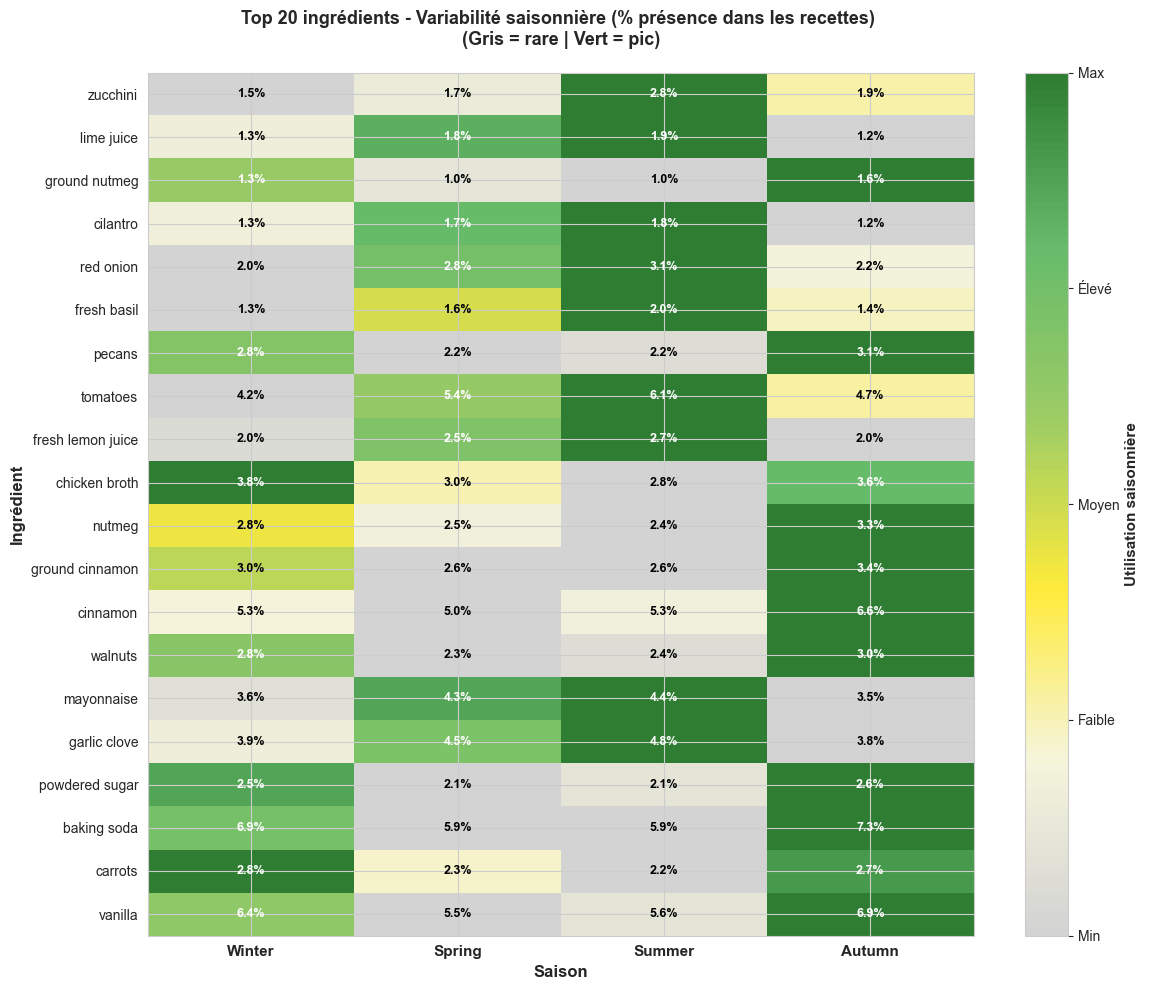


✅ Visualisation terminée!


In [15]:
# 📊 ANALYSE DES INGRÉDIENTS PAR SAISON
from collections import Counter

print("🔄 Extraction et analyse des ingrédients par saison...")

# --- 1. EXTRACTION DES INGRÉDIENTS ---
ingredients_by_season = {}
n_recipes_by_season = {}

for season in season_order:
    season_df = df.filter(pl.col('season') == season)
    n_recipes_by_season[season] = season_df.height
    
    # Compter les ingrédients
    ingredient_counts = (
        season_df.select(pl.col('ingredients').explode())
        .group_by('ingredients')
        .agg(pl.count().alias('count'))
        .to_pandas()
    )
    
    ingredients_by_season[season] = dict(zip(ingredient_counts['ingredients'], ingredient_counts['count']))
    print(f"  • {season}: {len(ingredients_by_season[season]):,} ingrédients dans {n_recipes_by_season[season]:,} recettes")

# --- 2. CALCUL DES FRÉQUENCES ET MÉTRIQUES ---
all_ingredients = set().union(*[set(ing.keys()) for ing in ingredients_by_season.values()])
print(f"\n✅ Total: {len(all_ingredients):,} ingrédients uniques")

# Matrice ingrédients × saisons
ingredients_matrix = [
    {'ingredient': ing, **{s: (ingredients_by_season[s].get(ing, 0) / n_recipes_by_season[s]) * 100 for s in season_order}}
    for ing in all_ingredients
]
ingredients_df = pd.DataFrame(ingredients_matrix)

# Métriques de variabilité
ingredients_df['std_seasonal'] = ingredients_df[season_order].std(axis=1)
ingredients_df['mean_freq'] = ingredients_df[season_order].mean(axis=1)
ingredients_df['cv'] = (ingredients_df['std_seasonal'] / ingredients_df['mean_freq']) * 100
ingredients_df['range'] = ingredients_df[season_order].max(axis=1) - ingredients_df[season_order].min(axis=1)

# --- 3. FILTRAGE ---
FREQ_THRESHOLD, RANGE_THRESHOLD = 1.0, 0.5 #pp = points de pourcentage (percentage points)
ingredients_df_filtered = ingredients_df[
    (ingredients_df['mean_freq'] >= FREQ_THRESHOLD) & 
    (ingredients_df['range'] >= RANGE_THRESHOLD)
].copy()

print(f"\n📊 Filtrage: {len(ingredients_df_filtered):,}/{len(ingredients_df):,} ingrédients")
print(f"  • Fréquence ≥ {FREQ_THRESHOLD}% | Range ≥ {RANGE_THRESHOLD}pp")

# Top 20 par coefficient de variation
top_variable = ingredients_df_filtered.nlargest(20, 'cv')
top_variable['max_season'] = top_variable[season_order].idxmax(axis=1)
top_variable['min_season'] = top_variable[season_order].idxmin(axis=1)

# --- 4. VISUALISATION : HEATMAP ---
fig, ax = plt.subplots(figsize=(12, 10))

heatmap_data_raw = top_variable[season_order].values
ingredient_labels = top_variable['ingredient'].values

# Normalisation [0, 1] : (x - min) / (max - min)
heatmap_data_normalized = np.array([
    (row - row.min()) / (row.max() - row.min()) if row.max() > row.min() else np.zeros_like(row)
    for row in heatmap_data_raw
])

# Colormap Gris → Jaune → Vert
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('gray_yellow_green', 
                                         ['#D3D3D3', '#F5F5DC', '#FFEB3B', '#9CCC65', '#66BB6A', '#2E7D32'], 
                                         N=100)

im = ax.imshow(heatmap_data_normalized, cmap=cmap, aspect='auto', vmin=0, vmax=1)

# Configuration
ax.set_xticks(np.arange(len(season_order)))
ax.set_yticks(np.arange(len(ingredient_labels)))
ax.set_xticklabels(season_order, fontsize=11, fontweight='bold')
ax.set_yticklabels(ingredient_labels, fontsize=10)

# Annotations
for i in range(len(ingredient_labels)):
    for j in range(len(season_order)):
        text_color = "black" if heatmap_data_normalized[i, j] < 0.6 else "white"
        ax.text(j, i, f'{heatmap_data_raw[i, j]:.1f}%',
                ha="center", va="center", color=text_color,
                fontsize=9, fontweight='bold')

# Colorbar
cbar = plt.colorbar(im, ax=ax, ticks=[0, 0.25, 0.5, 0.75, 1.0])
cbar.set_label('Utilisation saisonnière', fontsize=11, fontweight='bold')
cbar.ax.set_yticklabels(['Min', 'Faible', 'Moyen', 'Élevé', 'Max'])

ax.set_title('Top 20 ingrédients - Variabilité saisonnière (% présence dans les recettes) \n(Gris = rare | Vert = pic)',
             fontsize=13, fontweight='bold', pad=20)
ax.set_xlabel('Saison', fontsize=12, fontweight='bold')
ax.set_ylabel('Ingrédient', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Visualisation terminée!")

#### Tests statistiques

In [12]:
# 📊 TESTS STATISTIQUES : VARIABILITÉ DES INGRÉDIENTS

print("=" * 80)
print("📊 TESTS STATISTIQUES - INGRÉDIENTS PAR SAISON")
print("=" * 80)

# --- 1. TEST CHI-2 D'INDÉPENDANCE ---
print("\n1️⃣ TEST CHI-2 D'INDÉPENDANCE (TOP 20 INGRÉDIENTS)")
print("-" * 80)

chi2_results = []
for _, row in top_variable.head(20).iterrows():
    ingredient = row['ingredient']
    
    # Table de contingence : [présent, absent] × saisons
    contingency = np.array([
        [ingredients_by_season[s].get(ingredient, 0), n_recipes_by_season[s] - ingredients_by_season[s].get(ingredient, 0)]
        for s in season_order
    ]).T
    
    chi2_stat, p_val, dof, _ = stats.chi2_contingency(contingency)
    chi2_results.append({'ingredient': ingredient, 'chi2': chi2_stat, 'p': p_val, 'signif': p_val < 0.05})
    
    print(f"{'✅' if p_val < 0.05 else '❌'} {ingredient:<20} | χ²={chi2_stat:>8.2f} | p={p_val:.2e}")

# --- 2. SYNTHÈSE ---
n_signif = sum(r['signif'] for r in chi2_results)
print(f"\n📈 {n_signif}/{len(chi2_results)} ingrédients avec variabilité significative ({n_signif/len(chi2_results)*100:.0f}%)")

📊 TESTS STATISTIQUES - INGRÉDIENTS PAR SAISON

1️⃣ TEST CHI-2 D'INDÉPENDANCE (TOP 20 INGRÉDIENTS)
--------------------------------------------------------------------------------
✅ zucchini             | χ²=  248.61 | p=1.30e-53
✅ lime juice           | χ²=  139.87 | p=4.02e-30
✅ ground nutmeg        | χ²=   93.99 | p=3.05e-20
✅ cilantro             | χ²=   98.05 | p=4.07e-21
✅ red onion            | χ²=  164.43 | p=2.03e-35
✅ fresh basil          | χ²=   86.52 | p=1.22e-18
✅ pecans               | χ²=  136.79 | p=1.86e-29
✅ tomatoes             | χ²=  210.07 | p=2.82e-45
✅ fresh lemon juice    | χ²=   85.37 | p=2.16e-18
✅ chicken broth        | χ²=  108.79 | p=1.99e-23
✅ nutmeg               | χ²=   83.30 | p=6.02e-18
✅ ground cinnamon      | χ²=   88.64 | p=4.28e-19
✅ cinnamon             | χ²=  144.55 | p=3.95e-31
✅ walnuts              | χ²=   64.66 | p=5.94e-14
✅ mayonnaise           | χ²=   79.41 | p=4.10e-17
✅ garlic clove         | χ²=   83.26 | p=6.15e-18
✅ powdered sugar     

> **💡 Interprétation :**  
>  
> Les **tests du Chi-2** révèlent une **variabilité saisonnière significative (p < 0.05)** parmi les ingrédients les plus variables (**top 20**), confirmant que les **recettes postées varient clairement selon les saisons**. Ces différences traduisent des **habitudes culinaires marquées** et une adaptation aux **produits disponibles** au fil de l’année.  
>  
> En **été**, les recettes postées mettent en avant la **fraîcheur** et la **légèreté**, avec une forte présence de **légumes et herbes aromatiques** comme les courgettes ou les tomates.  
>  
> À l’inverse, les **recettes postées en automne** se tournent vers des **préparations plus riches et réconfortantes**, dominées par par exemple par des ingrédients comme le bicarbonate de soude (baking soda) ou les carottes, typiques de la **pâtisserie** et des **plats mijotés** ou **soupes**.

### Analyse 6: Évolution des tags
#### Visualisation

🔄 Extraction et analyse des tags par saison...
  • Winter: 491 tags dans 48,540 recettes
  • Spring: 498 tags dans 54,343 recettes
  • Summer: 495 tags dans 48,952 recettes
  • Autumn: 490 tags dans 48,231 recettes

✅ Total: 510 tags uniques

📊 Filtrage: 115/510 tags
  • Fréquence ≥ 1.0% | Range ≥ 0.5pp
  • Spring: 498 tags dans 54,343 recettes
  • Summer: 495 tags dans 48,952 recettes
  • Autumn: 490 tags dans 48,231 recettes

✅ Total: 510 tags uniques

📊 Filtrage: 115/510 tags
  • Fréquence ≥ 1.0% | Range ≥ 0.5pp


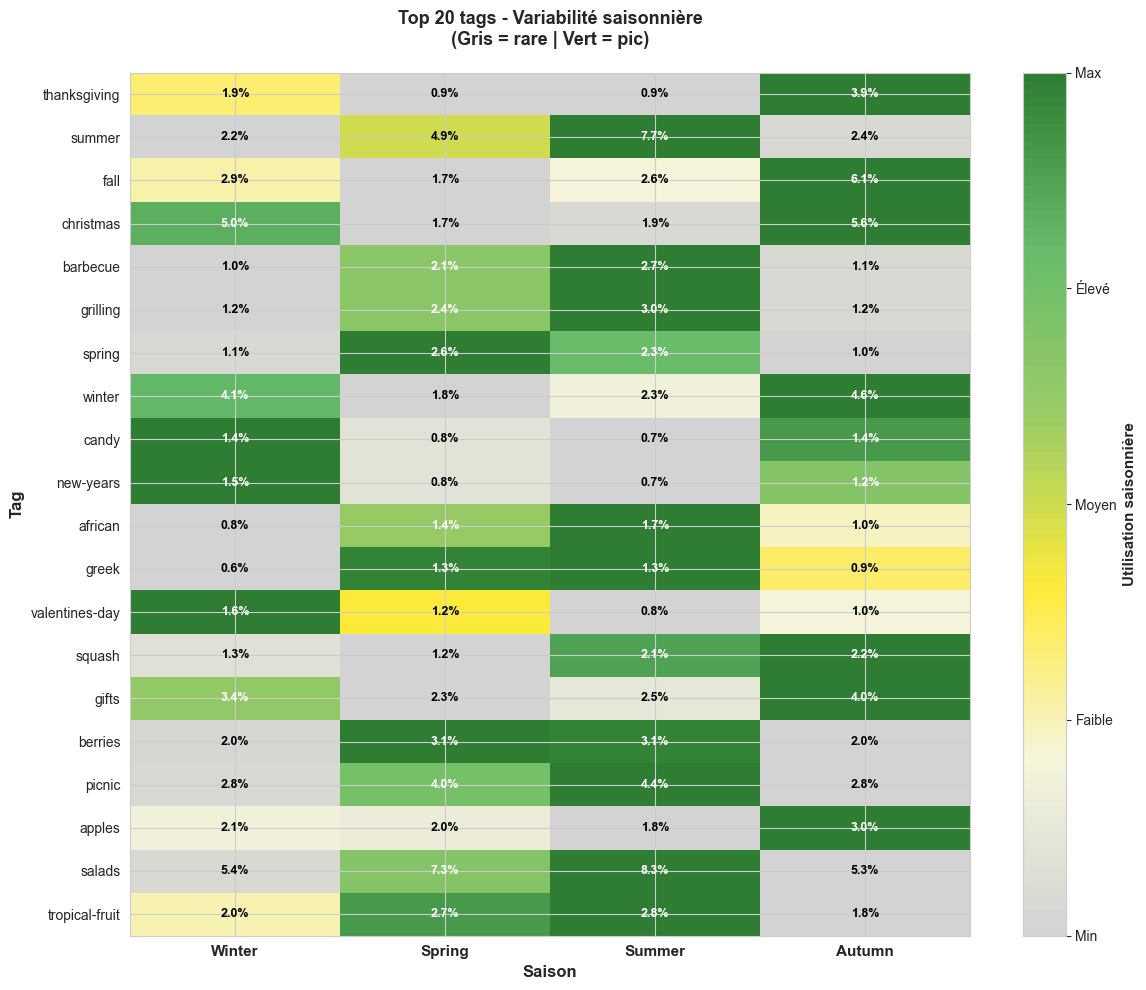


✅ Visualisation terminée!


In [13]:
# 📊 ANALYSE DES TAGS PAR SAISON
from collections import Counter

print("🔄 Extraction et analyse des tags par saison...")

# --- 1. EXTRACTION DES TAGS ---
tags_by_season = {}
n_recipes_by_season_tags = {}

for season in season_order:
    season_df = df.filter(pl.col('season') == season)
    n_recipes_by_season_tags[season] = season_df.height
    
    # Compter les tags
    tag_counts = (
        season_df.select(pl.col('tags').explode())
        .group_by('tags')
        .agg(pl.count().alias('count'))
        .to_pandas()
    )
    
    tags_by_season[season] = dict(zip(tag_counts['tags'], tag_counts['count']))
    print(f"  • {season}: {len(tags_by_season[season]):,} tags dans {n_recipes_by_season_tags[season]:,} recettes")

# --- 2. CALCUL DES FRÉQUENCES ET MÉTRIQUES ---
all_tags = set().union(*[set(tag.keys()) for tag in tags_by_season.values()])
print(f"\n✅ Total: {len(all_tags):,} tags uniques")

# Matrice tags × saisons
tags_matrix = [
    {'tag': tag, **{s: (tags_by_season[s].get(tag, 0) / n_recipes_by_season_tags[s]) * 100 for s in season_order}}
    for tag in all_tags
]
tags_df = pd.DataFrame(tags_matrix)

# Métriques de variabilité
tags_df['std_seasonal'] = tags_df[season_order].std(axis=1)
tags_df['mean_freq'] = tags_df[season_order].mean(axis=1)
tags_df['cv'] = (tags_df['std_seasonal'] / tags_df['mean_freq']) * 100
tags_df['range'] = tags_df[season_order].max(axis=1) - tags_df[season_order].min(axis=1)

# --- 3. FILTRAGE ---
FREQ_THRESHOLD_TAGS, RANGE_THRESHOLD_TAGS = 1.0, 0.5
tags_df_filtered = tags_df[
    (tags_df['mean_freq'] >= FREQ_THRESHOLD_TAGS) & 
    (tags_df['range'] >= RANGE_THRESHOLD_TAGS)
].copy()

print(f"\n📊 Filtrage: {len(tags_df_filtered):,}/{len(tags_df):,} tags")
print(f"  • Fréquence ≥ {FREQ_THRESHOLD_TAGS}% | Range ≥ {RANGE_THRESHOLD_TAGS}pp")

# Top 20 par coefficient de variation
top_variable_tags = tags_df_filtered.nlargest(20, 'cv')
top_variable_tags['max_season'] = top_variable_tags[season_order].idxmax(axis=1)
top_variable_tags['min_season'] = top_variable_tags[season_order].idxmin(axis=1)

# --- 4. VISUALISATION : HEATMAP ---
fig, ax = plt.subplots(figsize=(12, 10))

heatmap_data_raw = top_variable_tags[season_order].values
tag_labels = top_variable_tags['tag'].values

# Normalisation [0, 1] : (x - min) / (max - min)
heatmap_data_normalized = np.array([
    (row - row.min()) / (row.max() - row.min()) if row.max() > row.min() else np.zeros_like(row)
    for row in heatmap_data_raw
])

# Colormap Gris → Jaune → Vert
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('gray_yellow_green', 
                                         ['#D3D3D3', '#F5F5DC', '#FFEB3B', '#9CCC65', '#66BB6A', '#2E7D32'], 
                                         N=100)

im = ax.imshow(heatmap_data_normalized, cmap=cmap, aspect='auto', vmin=0, vmax=1)

# Configuration
ax.set_xticks(np.arange(len(season_order)))
ax.set_yticks(np.arange(len(tag_labels)))
ax.set_xticklabels(season_order, fontsize=11, fontweight='bold')
ax.set_yticklabels(tag_labels, fontsize=10)

# Annotations
for i in range(len(tag_labels)):
    for j in range(len(season_order)):
        text_color = "black" if heatmap_data_normalized[i, j] < 0.6 else "white"
        ax.text(j, i, f'{heatmap_data_raw[i, j]:.1f}%',
                ha="center", va="center", color=text_color,
                fontsize=9, fontweight='bold')

# Colorbar
cbar = plt.colorbar(im, ax=ax, ticks=[0, 0.25, 0.5, 0.75, 1.0])
cbar.set_label('Utilisation saisonnière', fontsize=11, fontweight='bold')
cbar.ax.set_yticklabels(['Min', 'Faible', 'Moyen', 'Élevé', 'Max'])

ax.set_title('Top 20 tags - Variabilité saisonnière\n(Gris = rare | Vert = pic)',
             fontsize=13, fontweight='bold', pad=20)
ax.set_xlabel('Saison', fontsize=12, fontweight='bold')
ax.set_ylabel('Tag', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Visualisation terminée!")

#### Tests statistiques

In [14]:
# 📊 TESTS STATISTIQUES : VARIABILITÉ DES TAGS

print("=" * 80)
print("📊 TESTS STATISTIQUES - TAGS PAR SAISON")
print("=" * 80)

# --- 1. TEST CHI-2 D'INDÉPENDANCE ---
print("\n1️⃣ TEST CHI-2 D'INDÉPENDANCE (TOP 20 TAGS)")
print("-" * 80)

chi2_results_tags = []
for _, row in top_variable_tags.head(20).iterrows():
    tag = row['tag']
    
    # Table de contingence : [présent, absent] × saisons
    contingency = np.array([
        [tags_by_season[s].get(tag, 0), n_recipes_by_season_tags[s] - tags_by_season[s].get(tag, 0)]
        for s in season_order
    ]).T
    
    chi2_stat, p_val, dof, _ = stats.chi2_contingency(contingency)
    chi2_results_tags.append({'tag': tag, 'chi2': chi2_stat, 'p': p_val, 'signif': p_val < 0.05})
    
    print(f"{'✅' if p_val < 0.05 else '❌'} {tag:<30} | χ²={chi2_stat:>8.2f} | p={p_val:.2e}")

# --- 2. SYNTHÈSE ---
n_signif = sum(r['signif'] for r in chi2_results_tags)
print(f"\n📈 {n_signif}/{len(chi2_results_tags)} tags avec variabilité significative ({n_signif/len(chi2_results_tags)*100:.0f}%)")

📊 TESTS STATISTIQUES - TAGS PAR SAISON

1️⃣ TEST CHI-2 D'INDÉPENDANCE (TOP 20 TAGS)
--------------------------------------------------------------------------------
✅ thanksgiving                   | χ²= 1613.31 | p=0.00e+00
✅ summer                         | χ²= 2370.02 | p=0.00e+00
✅ fall                           | χ²= 1740.10 | p=0.00e+00
✅ christmas                      | χ²= 1852.82 | p=0.00e+00
✅ barbecue                       | χ²=  561.93 | p=1.80e-121
✅ grilling                       | χ²=  641.44 | p=1.05e-138
✅ spring                         | χ²=  551.27 | p=3.68e-119
✅ winter                         | χ²=  948.82 | p=2.28e-205
✅ candy                          | χ²=  213.91 | p=4.16e-46
✅ new-years                      | χ²=  190.52 | p=4.71e-41
✅ african                        | χ²=  210.71 | p=2.05e-45
✅ greek                          | χ²=  154.95 | p=2.25e-33
✅ valentines-day                 | χ²=  158.14 | p=4.63e-34
✅ squash                         | χ²=  217.48 | p=

#### Interprétation

> **💡 Interprétation :**  
> 
> **Les analyses de variabilité saisonnière des tags culinaires** montrent une **segmentation claire selon les saisons**, confirmant des **tendances cohérentes avec les périodes de l’année**. Les tags liés à des événements précis comme **thanksgiving (3.9%)** ou **christmas (5.6%)** culminent logiquement en **automne et hiver**, tandis que ceux associés à la convivialité estivale, tels que **summer (7.7%)**, **barbecue (2.7%)** et **grilling (2.4%)**, atteignent leur maximum en **été**.
>
> Au **printemps**, des tags de renouveau apparaissent comme **spring (2.6%)** ou **berries (3.1%)**, reflétant une cuisine plus fraîche et légère. L’**hiver**, quant à lui, se distingue par des thèmes de **réconfort et de fêtes** (**winter 4.6%**, gifts 3.4%, new-years 1.5%), témoignant d’une cuisine plus riche et traditionnelle.